# Talktorial 1

# Compound data acquisition (ChEMBL)

#### Developed in Pontificia Universidad Javeriana, 2021 and 2022 Bogota/Colombia 



## Aim of this talktorial

We learn how to extract data from ChEMBL:

* Find ligands which were tested on a certain target
* Filter by available bioactivity data
* Calculate pIC50 values
* Merge dataframes and draw extracted molecules

## Learning goals


### Theory

* ChEMBL database
    * ChEMBL web services
    * ChEMBL webresource client
* Compound activity measures
    * IC50
    * pIC50

### Practical
    
Goal: Get list of compounds with bioactivity data for a given target

* Connect to ChEMBL database
* Get target data (ID Protein)
* Bioactivity data
    * Download and filter bioactivities
    * Clean and convert
* Compound data
    * Get list of compounds
    * Prepare output data
* Output
    * Draw molecules with highest pIC50
    * Write output file


## References

* ChEMBL bioactivity database (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5210557/)
* ChEMBL web services: <i>Nucleic Acids Res.</i> (2015), <b>43</b>, 612-620 (https://academic.oup.com/nar/article/43/W1/W612/2467881) 
* ChEMBL webrescource client GitHub (https://github.com/chembl/chembl_webresource_client)
* myChEMBL webservices version 2.x (https://github.com/chembl/mychembl/blob/master/ipython_notebooks/09_myChEMBL_web_services.ipynb)
* ChEMBL web-interface (https://www.ebi.ac.uk/chembl/)
* EBI-RDF platform (https://www.ncbi.nlm.nih.gov/pubmed/24413672)
* IC50 and pIC50 (https://en.wikipedia.org/wiki/IC50)
* UniProt website (https://www.uniprot.org/)

_____________________________________________________________________________________________________________________


## Theory

### ChEMBL database

* Open large-scale bioactivity database
* **Current data content (as of 10.2018):**
    * \>1.8 million distinct compound structures
    * \>15 million activity values from 1 million assays
    * Assays are mapped to ∼12 000 targets
* **Data sources** include scientific literature, PubChem bioassays, Drugs for Neglected Diseases Initiative (DNDi), BindingDB database, ...
* ChEMBL data can be accessed via a [web-interface](https://www.ebi.ac.uk/chembl/), the [EBI-RDF platform](https://www.ncbi.nlm.nih.gov/pubmed/24413672) and the [ChEMBL web services](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4489243/#B5)
 
    
#### ChEMBL web services

* RESTful web service
* ChEMBL web service version 2.x resource schema: 

[![ChEMBL web service schema](images/chembl_webservices_schema_diagram.jpg)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4489243/figure/F2/)

*Figure 1:* 
"ChEMBL web service schema diagram. The oval shapes represent ChEMBL web service resources and the line between two resources indicates that they share a common attribute. The arrow direction shows where the primary information about a resource type can be found. A dashed line indicates the relationship between two resources behaves differently. For example, the `Image` resource provides a graphical based representation of a `Molecule`."
Figure and description taken from: [<i>Nucleic Acids Res.</i> (2015), <b>43</b>, 612-620](https://academic.oup.com/nar/article/43/W1/W612/2467881).


#### ChEMBL webresource client

* Python client library for accessing ChEMBL data
* Handles interaction with the HTTPS protocol
* Lazy evaluation of results -> reduced number of network requests

### Compound activity measures

#### IC50 

* [Half maximal inhibitory concentration](https://en.wikipedia.org/wiki/IC50)
* Indicates how much of a particular drug or other substance is needed to inhibit a given biological process by half

[<img src="https://upload.wikimedia.org/wikipedia/commons/8/81/Example_IC50_curve_demonstrating_visually_how_IC50_is_derived.png" width="450" align="center" >](https://commons.wikimedia.org/wiki/File:Example_IC50_curve_demonstrating_visually_how_IC50_is_derived.png)

*Figure 2:* Visual demonstration of how to derive an IC50 value: Arrange data with inhibition on vertical axis and log(concentration) on horizontal axis; then identify max and min inhibition; then the IC50 is the concentration at which the curve passes through the 50% inhibition level.

#### pIC50

* To facilitate the comparison of IC50 values, we define pIC50 values on a logarithmic scale, such that <br />
    $ pIC_{50} = -log_{10}(IC_{50}) $ where $ IC_{50}$ is specified in units of M.
* Higher pIC50 values indicate exponentially greater potency of the drug
* pIC50 is given in terms of molar concentration (mol/L or M) <br />
    * IC50 should be specified in M to convert to pIC50  
    * For nM: $pIC_{50} = -log_{10}(IC_{50}*10^{-9})= 9-log_{10}(IC_{50}) $
    
Besides, IC50 and pIC50, other bioactivity measures are used, such as the equilibrium constant [KI](https://en.wikipedia.org/wiki/Equilibrium_constant) and the half maximal effective concentration  [EC50](https://en.wikipedia.org/wiki/EC50).

## Practical

In the following, we want to download all molecules that have been tested against our target of interest, the ID Protein.

### Connect to ChEMBL database

First, the ChEMBL webresource client as well as other python libraries are imported.

In [55]:
from chembl_webresource_client.new_client import new_client
import pandas as pd
import math
import numpy as np
from rdkit.Chem import PandasTools

In [2]:
# ! pip install chembl_webresource_client #COMENTARIO: para inicial el cuaderno esto uya debería estar instalado

In [3]:
# ! conda install -c rdkit rdkit -y #COMENTARIO: para inicial el cuaderno esto uya debería estar instalado

Create resource objects for API access.

In [4]:
targets = new_client.target
compounds = new_client.molecule
bioactivities = new_client.activity

## Target data

* Get UniProt-ID [http://www.uniprot.org/uniprot/](http://www.uniprot.org/uniprot/) of the target of interest (ID Protein) from UniProt website [https://www.uniprot.org/](https://www.uniprot.org/)
* Use UniProt-ID to get target information
* Select a different UniProt-ID if you are interested into another target

In [5]:
uniprot_id = 'P49841'
# Get target information from ChEMBL but restrict to specified values only
target_P49841 = targets.get(target_components__accession=uniprot_id).only('target_chembl_id', 'organism', 'pref_name', 'target_type')
pd.DataFrame.from_records(target_P49841)

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Glycogen synthase kinase-3 beta,CHEMBL262,SINGLE PROTEIN
1,Homo sapiens,Glycogen synthase kinase-3 beta,CHEMBL262,SINGLE PROTEIN
2,Homo sapiens,Glycogen synthase kinase-3,CHEMBL2095188,PROTEIN FAMILY
3,Homo sapiens,Axin-1/Glycogen synthase kinase-3 beta,CHEMBL3883309,PROTEIN-PROTEIN INTERACTION


### After checking the entries, we select the first entry as our target of interest
`CHEMBL"Number ID Protein"`: It is a single protein and represents the human Epidermal growth factor receptor (ID Protein, also named erbB1) 

In [6]:
target = target_P49841[0]
target

{'organism': 'Homo sapiens',
 'pref_name': 'Glycogen synthase kinase-3 beta',
 'target_chembl_id': 'CHEMBL262',
 'target_type': 'SINGLE PROTEIN'}

Save selected ChEMBL-ID.

In [7]:
chembl_id = target['target_chembl_id']
chembl_id

'CHEMBL262'

### Bioactivity data

Now, we want to query bioactivity data for the target of interest.

#### Download and filter bioactivities for the target

In this step, we download and filter the bioactivity data and only consider

* human proteins
* bioactivity type IC50
* exact measurements (relation '=')    
* binding data (assay type 'B') # buscar ojoooooooo


In [8]:
bioact = list(bioactivities.filter(target_chembl_id = chembl_id) \
                      .filter(type = 'IC50') \
                      .filter(relation = '=') \
                      .filter(assay_type = 'B') \
                      .only('activity_id','assay_chembl_id', 'assay_description', 'assay_type', \
                            'molecule_chembl_id', 'type', 'units', 'relation', 'value', \
                            'target_chembl_id', 'target_organism'))
len(bioact), len(bioact[0]), type(bioact), type(bioact[0])

(2454, 11, list, dict)

If you experience difficulties to query the ChEMBL database, we provide here a file containing the results for the query in the previous cell (11 April 2019). We do this using the Python package pickle which serializes Python objects so they can be saved to a file, and loaded in a program again later on.
(Learn more about object serialization on [DataCamp](https://www.datacamp.com/community/tutorials/pickle-python-tutorial))

You can load the "pickled" compounds by uncommenting and running the next cell.

In [9]:
#import pickle
#bioact = pickle.load(open("../data/T1/name of the ID Protein", "rb"))

#### Clean and convert bioactivity data

The data is stored as a list of dictionaries

In [10]:
bioact[0]

{'activity_id': 105841,
 'assay_chembl_id': 'CHEMBL686321',
 'assay_description': 'Inhibitory activity against human glycogen synthase kinase-3beta (GSK3-beta) at 100 uM ATP',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL322970',
 'relation': '=',
 'target_chembl_id': 'CHEMBL262',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'uM',
 'value': '0.38'}

Convert to pandas dataframe (this might take some minutes).

In [11]:
bioact_df = pd.DataFrame(bioact)
bioact_df.head(10)

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,target_chembl_id,target_organism,type,units,value
0,105841,CHEMBL686321,Inhibitory activity against human glycogen syn...,B,CHEMBL322970,=,CHEMBL262,Homo sapiens,IC50,uM,0.38
1,114696,CHEMBL686321,Inhibitory activity against human glycogen syn...,B,CHEMBL112564,=,CHEMBL262,Homo sapiens,IC50,uM,6.92
2,118600,CHEMBL686321,Inhibitory activity against human glycogen syn...,B,CHEMBL321421,=,CHEMBL262,Homo sapiens,IC50,uM,0.41
3,118601,CHEMBL686321,Inhibitory activity against human glycogen syn...,B,CHEMBL388978,=,CHEMBL262,Homo sapiens,IC50,uM,0.16
4,124758,CHEMBL686321,Inhibitory activity against human glycogen syn...,B,CHEMBL115875,=,CHEMBL262,Homo sapiens,IC50,uM,9.6
5,127559,CHEMBL686321,Inhibitory activity against human glycogen syn...,B,CHEMBL325353,=,CHEMBL262,Homo sapiens,IC50,uM,0.1
6,127564,CHEMBL686321,Inhibitory activity against human glycogen syn...,B,CHEMBL113168,=,CHEMBL262,Homo sapiens,IC50,uM,1.16
7,128504,CHEMBL686321,Inhibitory activity against human glycogen syn...,B,CHEMBL112483,=,CHEMBL262,Homo sapiens,IC50,uM,9.3
8,134878,CHEMBL686321,Inhibitory activity against human glycogen syn...,B,CHEMBL323944,=,CHEMBL262,Homo sapiens,IC50,uM,0.24
9,136172,CHEMBL686321,Inhibitory activity against human glycogen syn...,B,CHEMBL113272,=,CHEMBL262,Homo sapiens,IC50,uM,0.1


In [12]:
bioact_df.shape

(2454, 11)

Delete entries with missing values.

In [13]:
bioact_df = bioact_df.dropna(axis=0, how = 'any')
bioact_df.shape

(2454, 11)

Delete duplicates:
Sometimes the same molecule (`molecule_chembl_id`) has been tested more than once, in this case, we only keep the first one.

In [14]:
bioact_df = bioact_df.drop_duplicates('molecule_chembl_id', keep = 'first')
bioact_df.shape

(2142, 11)

We would like to only keep bioactivity data measured in molar units. The following print statements will help us to see what units are contained and to control what is kept after dropping some rows.

In [16]:
print(bioact_df.units.unique())
bioact_df = bioact_df.drop(bioact_df.index[~bioact_df.units.str.contains('M')])
print(bioact_df.units.unique())
bioact_df.shape

['uM' 'nM' 'M' 'pM' 'microM' 'mM']
['uM' 'nM' 'M' 'pM' 'microM' 'mM']


(2140, 11)

Since we deleted some rows, but we want to iterate over the index later, we reset index to be continuous.

In [17]:
bioact_df = bioact_df.reset_index(drop=True) 
bioact_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,target_chembl_id,target_organism,type,units,value
0,105841,CHEMBL686321,Inhibitory activity against human glycogen syn...,B,CHEMBL322970,=,CHEMBL262,Homo sapiens,IC50,uM,0.38
1,114696,CHEMBL686321,Inhibitory activity against human glycogen syn...,B,CHEMBL112564,=,CHEMBL262,Homo sapiens,IC50,uM,6.92
2,118600,CHEMBL686321,Inhibitory activity against human glycogen syn...,B,CHEMBL321421,=,CHEMBL262,Homo sapiens,IC50,uM,0.41
3,118601,CHEMBL686321,Inhibitory activity against human glycogen syn...,B,CHEMBL388978,=,CHEMBL262,Homo sapiens,IC50,uM,0.16
4,124758,CHEMBL686321,Inhibitory activity against human glycogen syn...,B,CHEMBL115875,=,CHEMBL262,Homo sapiens,IC50,uM,9.6


To allow further comparison of the IC50 values, we convert all units to nM. First, we write a helper function, which can be applied to the whole dataframe in the next step.

In [18]:
def convert_to_NM(unit, bioactivity):
#     c=0
# for i, unit in enumerate(bioact_df.units):
    if unit != "nM":        
        if unit == "pM":
            value = float(bioactivity)/1000
        elif unit == "10'-11M":
            value = float(bioactivity)/100
        elif unit == "10'-10M":
            value = float(bioactivity)/10    
        elif unit == "10'-8M":
            value = float(bioactivity)*10
        elif unit == "10'-1microM" or unit == "10'-7M":
            value = float(bioactivity)*100
        elif unit == "uM" or unit == "/uM" or unit == "10'-6M" or unit=="microM":
            value = float(bioactivity)*1000      
        elif unit == "10'1 uM":
            value = float(bioactivity)*10000
        elif unit == "10'2 uM":
            value = float(bioactivity)*100000
        elif unit == "mM":
            value = float(bioactivity)*1000000
        elif unit == "M":
            value = float(bioactivity)*1000000000
        else:
            print ('unit not recognized...', unit)
        return value
    else: return bioactivity

In [19]:
bioactivity_nM = []
for i, row in bioact_df.iterrows():
    bioact_nM = convert_to_NM(row['units'], row['value'])
    bioactivity_nM.append(bioact_nM)
bioact_df['value'] = bioactivity_nM
bioact_df['units'] = 'nM'
bioact_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,target_chembl_id,target_organism,type,units,value
0,105841,CHEMBL686321,Inhibitory activity against human glycogen syn...,B,CHEMBL322970,=,CHEMBL262,Homo sapiens,IC50,nM,380.0
1,114696,CHEMBL686321,Inhibitory activity against human glycogen syn...,B,CHEMBL112564,=,CHEMBL262,Homo sapiens,IC50,nM,6920.0
2,118600,CHEMBL686321,Inhibitory activity against human glycogen syn...,B,CHEMBL321421,=,CHEMBL262,Homo sapiens,IC50,nM,410.0
3,118601,CHEMBL686321,Inhibitory activity against human glycogen syn...,B,CHEMBL388978,=,CHEMBL262,Homo sapiens,IC50,nM,160.0
4,124758,CHEMBL686321,Inhibitory activity against human glycogen syn...,B,CHEMBL115875,=,CHEMBL262,Homo sapiens,IC50,nM,9600.0


### Compound data

We have a data frame containing all molecules tested (with the respective measure) against ID Protein. Now, we want to get the molecules that are stored behind the respective ChEMBL IDs. 

#### Get list of compounds

Let's have a look at the compounds from ChEMBL we have defined bioactivity data for. First, we retrieve ChEMBL ID and structures for the compounds with desired bioactivity data.

In [20]:
cmpd_id_list = list(bioact_df['molecule_chembl_id'])
compound_list = compounds.filter(molecule_chembl_id__in = cmpd_id_list) \
                         .only('molecule_chembl_id','molecule_structures')

Then, we convert the list to a pandas dataframe and delete duplicates (again, the pandas from_records function might take some time).

In [64]:
compound_df = pd.DataFrame(compound_list)
compound_df = compound_df.drop_duplicates('molecule_chembl_id', keep = 'first')
print(compound_df.shape)
print(bioact_df.shape)
compound_df.head()

(2140, 2)
(2140, 11)


,molecule_chembl_id,molecule_structures
0,CHEMBL6246,{'canonical_smiles': 'O=c1oc2c(O)c(O)cc3c(=O)o...
1,CHEMBL6291,{'canonical_smiles': 'Cn1cc(C2=C(c3cn(CCCSC(=N...
2,CHEMBL28,{'canonical_smiles': 'O=c1cc(-c2ccc(O)cc2)oc2c...
3,CHEMBL7463,{'canonical_smiles': 'CN(C)CCCn1cc(C2=C(c3c[nH...
4,CHEMBL50,{'canonical_smiles': 'O=c1c(O)c(-c2ccc(O)c(O)c...


So far, we have multiple different molecular structure representations. We only want to keep the canonical SMILES.

In [65]:
for i, cmpd in compound_df.iterrows():
    if compound_df.loc[i]['molecule_structures'] is not None:
        compound_df.loc[i]['molecule_structures'] = cmpd['molecule_structures']['canonical_smiles']

print (compound_df.shape)

(2140, 2)


#### Prepare output data

Merge values of interest in one dataframe on ChEMBL-IDs:
* ChEMBL-IDs
* SMILES
* units
* IC50

In [32]:
output_df = pd.merge(bioact_df[['molecule_chembl_id','units','value']], compound_df, on='molecule_chembl_id')
print(output_df.shape)
output_df.head()

(2140, 4)


,molecule_chembl_id,units,value,molecule_structures
0,CHEMBL322970,nM,380.0,O=C1NC(=O)C(c2ccccc2[N+](=O)[O-])=C1Nc1ccc(O)c...
1,CHEMBL112564,nM,6920.0,CN(C)Cc1c(-c2n[nH]c(-c3ccncc3)n2)nnn1-c1nonc1N
2,CHEMBL321421,nM,410.0,CCN(CC)Cc1c(C(=O)N/N=C/c2ccncc2)nnn1-c1nonc1N
3,CHEMBL388978,nM,160.0,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...
4,CHEMBL115875,nM,9600.0,NNC(=O)c1nnn(-c2nonc2N)c1CN1CCCCC1


For distinct column names, we rename IC50 and SMILES columns.

In [43]:
output_df = output_df.rename(columns= {'molecule_structures':'smiles', 'value':'IC50'})
output_df.shape

(2139, 4)

If we do not have a SMILES representation of a compound, we can not further use it in the following talktorials. Therefore, we delete compounds without SMILES column.

In [44]:
output_df = output_df[~output_df['smiles'].isnull()]
print(output_df.shape)
output_df.head()

(2139, 4)


,molecule_chembl_id,units,IC50,smiles
0,CHEMBL322970,nM,380.0,O=C1NC(=O)C(c2ccccc2[N+](=O)[O-])=C1Nc1ccc(O)c...
1,CHEMBL112564,nM,6920.0,CN(C)Cc1c(-c2n[nH]c(-c3ccncc3)n2)nnn1-c1nonc1N
2,CHEMBL321421,nM,410.0,CCN(CC)Cc1c(C(=O)N/N=C/c2ccncc2)nnn1-c1nonc1N
3,CHEMBL388978,nM,160.0,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...
4,CHEMBL115875,nM,9600.0,NNC(=O)c1nnn(-c2nonc2N)c1CN1CCCCC1


In the next cell, you see that the low IC50 values are difficult to read. Therefore, we prefer to convert the IC50 values to pIC50.

In [49]:
output_df = output_df.reset_index(drop=True)
ic50 = output_df.IC50
print(len(ic50))
print(ic50.head(10))

2139
0     380.0
1    6920.0
2     410.0
3     160.0
4    9600.0
5     100.0
6    1160.0
7    9300.0
8     240.0
9     100.0
Name: IC50, dtype: object


In [59]:
output_df['pIC50'] = 9 - np.log10(output_df.IC50.astype(float))
output_df.head()

,molecule_chembl_id,units,IC50,smiles,pIC50
0,CHEMBL322970,nM,380.0,O=C1NC(=O)C(c2ccccc2[N+](=O)[O-])=C1Nc1ccc(O)c...,6.420216
1,CHEMBL112564,nM,6920.0,CN(C)Cc1c(-c2n[nH]c(-c3ccncc3)n2)nnn1-c1nonc1N,5.159894
2,CHEMBL321421,nM,410.0,CCN(CC)Cc1c(C(=O)N/N=C/c2ccncc2)nnn1-c1nonc1N,6.387216
3,CHEMBL388978,nM,160.0,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,6.795880
4,CHEMBL115875,nM,9600.0,NNC(=O)c1nnn(-c2nonc2N)c1CN1CCCCC1,5.017729


### Collected bioactivity data for ID Protein

Let's have a look at our collected data set.
#### Draw molecules
In the next steps, we add a molecule column to our datafame and look at the structures of the molecules with the highest pIC50 values. 

In [60]:
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol='smiles')

Sort molecules by pIC50.

In [61]:
output_df.sort_values(by="pIC50", ascending=False, inplace=True)
output_df.reset_index(drop=True, inplace=True)

Show the most active molecules = molecules with the highest pIC50 values.

,molecule_chembl_id,units,IC50,pIC50,ROMol
0,CHEMBL2386094,nM,0.013,10.886057,
1,CHEMBL3895998,nM,0.1,10.000000,
2,CHEMBL4084855,nM,0.1,10.000000,
3,CHEMBL564450,nM,0.14,9.853872,
4,CHEMBL4063206,nM,0.2,9.698970,

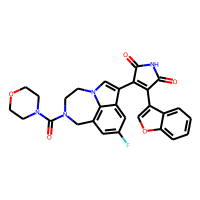
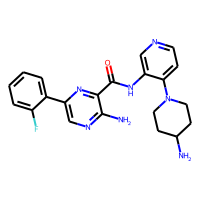
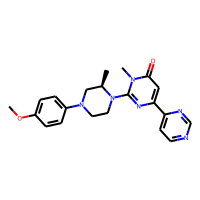
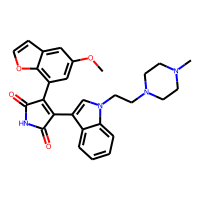
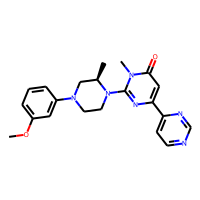

In [62]:
output_df.drop("smiles", axis=1).head()

#### Write output file
To use the data for the following talktorials, we save the data as csv file. Note that it is advisable to drop the molecule column (only contains an image of the molecules) when saving the data.

# Talktorial 2

# Molecular filtering: ADME and lead-likeness criteria

#### Developed in Pontificia Universidad Javeriana Bogota/Colombia



## Aim of this talktorial

The compounds acquired from ChEMBL (**talktorial 1**) will be filtered by lead-likeliness criteria in order to remove less drug-like molecules from our screening library.

* Calculate molecular parameters related to bioavailability of compounds (Lipinski's rule of five)
* Filter compounds collected from ChEMBL by rule of five criteria
* Plot parameters in form of radar chart

## Learning goals

### Theory
* ADME - absorption, distribution, metabolism and excretion
* Lead-likeliness and Lipinski's rule of five
* Variations and interpretation of radar charts in the context of lead-likeliness

### Practical
* Calculate physicochemical parameters for example compounds
* Generate bar plots to compare individual physicochemical parameters for multiple molecules
* Write a function to check compliance with rule of five
* Apply rule of five to whole dataset retrieved from ChEMBL
* Generate a radar chart of our dataset filtered by the rule of five. This helps to visualize the properties in context of the rule of five criteria in one plot.

## References

* ADME criteria: ADME description (https://en.wikipedia.org/wiki/ADME) and ([<i>Mol Pharm.</i> (2010), <b>7(5)</b>, 1388-1405](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3025274/))
* SwissADME (http://www.swissadme.ch/)
* Lead compounds: (https://en.wikipedia.org/wiki/Lead_compound)
* LogP (https://en.wikipedia.org/wiki/Partition_coefficient)
* Lipinski, Christopher A., et al. "Experimental and computational approaches to estimate solubility and permeability in drug discovery and development settings." ([<i>Adv. Drug Deliv. Rev.</i> (1997), <b>23</b>, 3-25](https://www.sciencedirect.com/science/article/pii/S0169409X96004231))
* Ritchie et al. "Graphical representation of ADME-related molecule properties for medicinal chemists" ([<i>Drug. Discov. Today</i> (2011), <b>16</b>, 65-72](https://www.ncbi.nlm.nih.gov/pubmed/21074634))



## Theory

In a virtual screening we can predict whether a compound might bind to and interact with a specific target. However, if we want to identify a new drug, it is also important that this compound reaches the target and is eventually removed from the body in a favorable way. Therefore, we should also consider whether a compound is actually taken up into the body and whether it is able to cross certain barriers in order to reach its target. Is it metabolically stable and how will it be excreted once it is not acting at the target anymore? These processes are investigated in the field of pharmacokinetics. In contrast to pharmacodynamics ('What does the drug do to our body?'), pharmacokinetics deals with the question **'What happens to the drug in our body?'**. 

### ADME

Pharmacokinetics are mainly divided into four steps: 
<strong>A</strong>bsorption, 
<strong>D</strong>istribution, 
<strong>M</strong>etabolism, and 
<strong>E</strong>xcretion. 
These are summarized as <strong>ADME</strong>. Sometimes, ADME(T) also includes <strong>T</strong>oxicology. 
Below, the ADME steps are discussed more detailed.  
([ADME wikipedia](https://en.wikipedia.org/wiki/ADME) and [<i>Mol Pharm.</i> (2010), <b>7(5)</b>, 1388-1405](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3025274/))


<img src="images/adme.png" class="center" align="right" width="260"> 


* **Absorption**: The amount and the time it takes for a substance to be taken up into the body depends on multiple factors which can vary between individuals and their conditions as well as on the properties of the substance. Factors such as (poor) compound solubility, gastric emptying time, intestinal transit time, chemical (in-)stability in the stomach, and (in-)ability to permeate the intestinal wall can all influence the extent to which a drug is absorbed after e.g. oral administration, inhalation or contact to skin.
<br><br>
* **Distribution**: The distribution of an absorbed substance, i.e. within the body, between blood and different tissues, and crossing of the blood-brain barrier are affected by regional blood flow rates, molecular size and polarity of the compound, and binding to serum proteins and transporter enzymes. Critical effects in toxicology can be accumulation of highly apolar substances in fatty tissue, or crossing of the blood-brain barrier.
<br><br>
* **Metabolism**: As soon as a compound enters the body, it usually starts to be metabolized. This means that only part of this compound will actually reach its target. Mainly liver and  kidney enzymes are responsible for the break down of xenobiotics (substances that are extrinsic to the body).  Reducing the amount of an absorbed substance can be favorable if a toxic compound is removed. On the other hand, transformation of a chemical could even yield new toxic metabolites. 
<br><br>
* **Excretion**: Compounds and their metabolites need to be removed from the body via excretion, usually through the kidneys (urine) or in the feces. Incomplete excretion can result in accumulation of foreign substances or adverse interference with normal metabolism.

<div align="right" width="250">Figure 1: ADME processes in the human body <br>
    (figure taken from openclipart.org and adapted) </div>



###  Lead-likeness and Lipinski's rule of five

[<strong>Lead</strong> compounds](https://en.wikipedia.org/wiki/Lead_compound) are developmental drug candidates with promising properties. They are used as starting structures and modified with the aim to find desired drugs. Besides bioactivity (*'Compound binds to the target of interest.'*), also favorable ADME properties are important criteria for the design of efficient drugs. 

The bioavailability of a compound is an important ADME property, to measure this property solely based on a compounds structure, Lipinski's rule of five was invented. This is a a rule of thumb, which helps to estimate oral bioavailability of a compound.

According to the rule of five, a substance is most likely not orally bioavailable if it violates more than one of the following rules:

* Molecular weight is less or equal to 500 Daltons
* Not more than 10 hydrogen bond acceptors
* Not more than 5 hydrogen bond donors
* LogP (octanol-water coefficient) <= 5

[LogP](https://en.wikipedia.org/wiki/Partition_coefficient) is also called partition coefficient or octanol-water coefficient. It measures the distribution of a compound, usually between a hydrophobic (e.g. 1-octanol) and a hydrophilic (e.g. water) phase. 

Hydrophobic molecules might have a reduced solubility in water, while more hydrophilic molecules (e.g. high number of hydrogen bond acceptors and donors) or large molecules (high molecular weight) might have more difficulties in passing phospholipid membranes.

As for the rule of five, note that all numbers are multiples of five; this is the origin of the rule's name.

([<i>Adv. Drug Deliv. Rev.</i> (1997), <b>23</b>, 3-25](https://www.sciencedirect.com/science/article/pii/S0169409X96004231))



### Radar charts

<img src="images/radarplot.png" class="center" align="right" width="250"> 

After calculating the molecular properties related to the rule of five, it can be helpful to visualize them. Ritchie et al. ([<i>Drug. Discov. Today</i> (2011), <b>16(1-2)</b>, 65-72](https://www.ncbi.nlm.nih.gov/pubmed/21074634)) provided an overview on graphical representations of ADME-related properties: 
There are multiple ways (e.g. craig plots, flower plots, or golden triangle) to visualize molecular properties and, thus, to support the interpretation by medicinal chemists. 

In this tutorial, you learn how to generate a radar plot using the python plotting library `matplotlib`.
Due to their appearance, radar charts ([radar charts wikipedia](https://en.wikipedia.org/wiki/Radar_chart)) are sometimes also called ‘spider’ or ‘cobweb’ plots. 
They are arranged circularly in 360 degrees and have one axis, starting in the center, for each condition. The values for each parameter are plotted on the axis and connected with a line. 
A shaded area can indicate the region where the parameters meet the conditions.

<div align="right" width="250">Figure 2: Radar plot displaying physico- <br> chemical properties of a compound dataset </div>




## Practical



### Define example molecules and visualize them

Before working with the whole dataset retrieved from ChEMBL, we pick four example compounds to investigate their chemical properties.
We import the necessary libraries, start from the SMILES of four example molecules and draw them.

In [30]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
from rdkit.Chem import Draw
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from math import pi

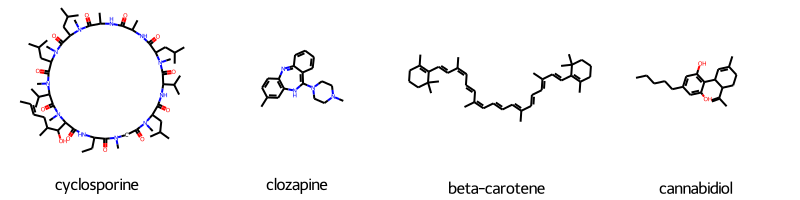

In [31]:
smiles_1 = 'CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(C(=O)NC(C(=O)N(C(C(=O)N(C(C(=O)N(C(C(=O)N(C(C(=O)N1)C(C(C)CC=CC)O)C)C(C)C)C)CC(C)C)C)CC(C)C)C)C)C)CC(C)C)C)C(C)C)CC(C)C)C)C' # Cyclosporine
smiles_2 = 'CN1CCN(CC1)C2=C3C=CC=CC3=NC4=C(N2)C=C(C=C4)C' # Clozapine
smiles_3 = 'CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=C(C)C=CC2=C(CCCC2(C)C)C)C)C' # Beta-carotene
smiles_4 = 'CCCCCC1=CC(=C(C(=C1)O)C2C=C(CCC2C(=C)C)C)O' # Cannabidiol
smiles_list = [smiles_1, smiles_2, smiles_3, smiles_4]
names_list = ['cyclosporine', 'clozapine', 'beta-carotene', 'cannabidiol']
mol_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

Draw.MolsToGridImage(mol_list, legends=names_list, molsPerRow=4)


### Calculate rule of five molecular properties and plot them

The chemical properties relevant for the rule of five are calculated and visually compared:

* Calculate molecular weight, number of h-bond acceptors and donors, and logP.
*  Using the predefined functions in the [rdkit descriptor library](http://www.rdkit.org/docs/GettingStartedInPython.html#descriptor-calculation)

In [32]:
MWs = [Descriptors.ExactMolWt(mol) for mol in mol_list]
HBAs = [Descriptors.NumHAcceptors(mol) for mol in mol_list]
HBDs = [Descriptors.NumHDonors(mol) for mol in mol_list]
LogPs = [Descriptors.MolLogP(mol) for mol in mol_list]
parameters = [MWs, HBAs, HBDs, LogPs]
print('Molecular weight of the four compounds:',MWs)

Molecular weight of the four compounds: [1201.841367992, 306.184446704, 536.438201792, 314.2245802]


* Plot the properties per molecule as bar plots.

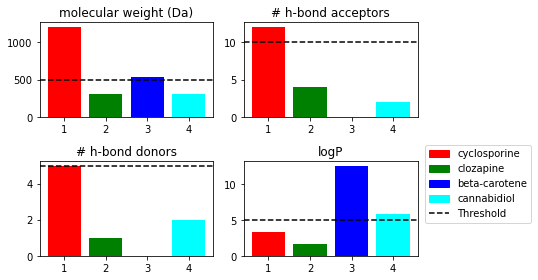

In [33]:
# Start 2x2 plot frame
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
axes = [ax1, ax2, ax3, ax4]
x = np.arange(1, len(mol_list)+1)
colors = ['red', 'green', 'blue', 'cyan']

# Create subplots
for index in x-1:
    axes[index].bar(x, parameters[index], color=colors)

# Add rule of five thresholds as dashed lines
ax1.axhline(y=500, color="black", linestyle="dashed")
ax1.set_title("molecular weight (Da)")
ax2.axhline(y=10, color="black", linestyle="dashed")
ax2.set_title("# h-bond acceptors")
ax3.axhline(y=5, color="black", linestyle="dashed")
ax3.set_title("# h-bond donors")
ax4.axhline(y=5, color="black", linestyle="dashed")
ax4.set_title("logP")

# Add legend
legend_elements = [mpatches.Patch(color=colors[i], label=names_list[i]) for i in range(len(mol_list))]
legend_elements.append(Line2D([0], [0], color="black", ls="dashed", label="Threshold"))
fig.legend(handles=legend_elements, bbox_to_anchor=(1.25, 0.5))

# Fit subplots and legend into figure
plt.tight_layout()

plt.show()

In the above bar chart we compared the rule of five properties (molecular weight, number of hydrogen bond donors and acceptors, LogP) for four example molecules. We can see that the four example drug molecules have different properties. In the next steps, we will investigate for each compound individually whether it violates the rule of five.

### Investigate compliance with Lipinski's rule of five

A function is defined to investigate whether a compound violates the rule of five and is applied to our example compounds.

In [34]:
def test_rule_of_five(smi):
    m = Chem.MolFromSmiles(smi)
    
    # Calculate rule of five chemical properties
    MW = Descriptors.ExactMolWt(m)
    HBA = Descriptors.NumHAcceptors(m)
    HBD = Descriptors.NumHDonors(m)
    LogP = Descriptors.MolLogP(m)
    
    # Rule of five conditions
    conditions = [MW <= 500, HBA <= 10, HBD <= 5, LogP <= 5]
    # Return True if no more than one out of four conditions is violated
    return conditions.count(True) >= 3

In [35]:
for i in range(len(smiles_list)):
    smi=smiles_list[i]
    name=names_list[i]
    print("Rule of five accepted for %s: %s "%(name,test_rule_of_five(smi)))  

Rule of five accepted for cyclosporine: False 
Rule of five accepted for clozapine: True 
Rule of five accepted for beta-carotene: False 
Rule of five accepted for cannabidiol: True 


Our `test_rule_of_five` function yields that two of the four example molecules do not pass the rule of five. From this we can interpret that cyclosporin and betacarotene are most likely not orally bioavailable. As all of them are available on the market as drugs, they must reach their target somehow. They could be exceptions of the rule, or they might be administered via a route different from oral administration. 

### Apply rule of five to the ID protein dataset

The `test_rule_of_five` function can be used to filter the main dataset by compliance with Lipinski's rule of five.

* Adjust the function to return all chemical parameters related to the rule of five
* Load main dataframe (`ChEMBL_df`)
* Apply rule of five function to `ChEMBL_df`
* Filter `ChEMBL_df` by  compounds that violate more than one rule
* Save filtered dataframe

In [36]:
def df_rule_of_five(df):
    
    smi = df['smiles']
    m = Chem.MolFromSmiles(smi)
    
    # Calculate rule of five chemical properties
    MW = Descriptors.ExactMolWt(m)
    HBA = Descriptors.NumHAcceptors(m)
    HBD = Descriptors.NumHDonors(m)
    LogP = Descriptors.MolLogP(m)
    
    # Rule of five conditions
    conditions = [MW <= 500, HBA <= 10, HBD <= 5, LogP <= 5]
    
    # Create pandas row for conditions results with values and information whether rule of five is violated
    return pd.Series([MW, HBA, HBD, LogP, 'yes']) if conditions.count(True) >= 3 else pd.Series([MW, HBA, HBD, LogP, 'no'])


### DATA DOWNLOAD 

DOWNLOAD THE DATA OBTAINED BY ChEMBL, ATTACHING FILE LOCATION ADDRESS IN .csv FORMAT

* THEN UPLOAD FILE USING THE ASSIGNED Location FOR THE EXTRACTED DATA IN .csv FORMAT

In [37]:
output_df.drop("ROMol", axis=1).to_csv("C:/Users/Hp/Desktop/tactorials1234entrega/tactorial unido/GSK3.csv")

In [38]:
ChEMBL_df = pd.read_csv('C:/Users/Hp/Desktop/tactorials1234entrega/tactorial unido/GSK3.csv', index_col=0)
print(ChEMBL_df.shape)
ChEMBL_df.head()

(2139, 5)


,molecule_chembl_id,units,IC50,smiles,pIC50
0,CHEMBL2386094,nM,0.013,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...,10.886057
1,CHEMBL3895998,nM,0.100,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1,10.000000
2,CHEMBL4084855,nM,0.100,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...,10.000000
3,CHEMBL564450,nM,0.140,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...,9.853872
4,CHEMBL4063206,nM,0.200,COc1cccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](...,9.698970


In [39]:
# Apply ruleOfFive to dataset to get rule of five results (may take a while)
rule5_prop_df = ChEMBL_df.apply(df_rule_of_five, axis=1)

# Name condition columns
rule5_prop_df.columns= ['MW', 'HBA', 'HBD', 'LogP', 'rule_of_five_conform']

In [40]:
# Concatenate dataset with computed values
ChEMBL_df = ChEMBL_df.join(rule5_prop_df)

In [41]:
# Delete empty rows --> rule of five
filtered_df = ChEMBL_df[ChEMBL_df['rule_of_five_conform']=='yes']


### UPDATED DATA

DOWNLOAD NEW DOCUMENT BY ASSIGNING A NEW NAME, BUT KEEPING THE SOURCE ADDRESS OF THE FIRST DOCUMENT, THIS FILE MUST BE SAVED IN .csv FORMAT

In [42]:
# Info about data
print('# of compounds in unfiltered data set:', len(ChEMBL_df))
print('# of compounds in filtered data set:', len(filtered_df))
print("# of compounds not compliant with Lipinski's rule of five:", (len(ChEMBL_df)-len(filtered_df)))

# Save filtered data 
filtered_df.to_csv('C:/Users/Hp/Desktop/tactorials1234entrega/tactorial unido/GSK3lan.csv', sep=';') 
filtered_df.head(10)

# of compounds in unfiltered data set: 2139
# of compounds in filtered data set: 2036
# of compounds not compliant with Lipinski's rule of five: 103


,molecule_chembl_id,units,IC50,smiles,pIC50,MW,HBA,HBD,LogP,rule_of_five_conform
0,CHEMBL2386094,nM,0.013,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...,10.886057,514.165248,6,1,3.3616,yes
1,CHEMBL3895998,nM,0.100,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1,10.000000,407.186987,7,3,2.4397,yes
2,CHEMBL4084855,nM,0.100,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...,10.000000,392.196074,8,0,1.9610,yes
3,CHEMBL564450,nM,0.140,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...,9.853872,484.211055,7,1,3.2107,yes
4,CHEMBL4063206,nM,0.200,COc1cccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](...,9.698970,392.196074,8,0,1.9610,yes
5,CHEMBL2386090,nM,0.200,O=C1NC(=O)C(c2cn3c4c(cccc24)CN(C(=O)c2cnccn2)C...,9.698970,489.143704,7,1,3.4007,yes
6,CHEMBL3957649,nM,0.200,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCNCC1,9.698970,393.171336,7,3,1.9218,yes
7,CHEMBL4077376,nM,0.200,C[C@@H]1CN(c2ccccc2F)CCN1c1nc(-c2ccncn2)cc(=O)n1C,9.698970,380.176088,7,0,2.0915,yes
8,CHEMBL3963605,nM,0.200,Nc1ncc(-c2ccccc2)nc1C(=O)Nc1cnccc1N1CCC(N)CC1,9.698970,389.196408,7,3,2.3006,yes
9,CHEMBL3942619,nM,0.200,COc1ccc(-c2cnc(N)c(C(=O)Nc3cnccc3N3CCC(N)CC3)n...,9.698970,419.206973,8,3,2.3092,yes



### Radar plot for visualization of rule of five properties

First, we define a function that defines the mean and standard deviations of a dataset. 

These statistics will be lateron used to plot the Lipinski's rule of five related parameters of a dataset.

In [43]:
def get_properties_stats(data_df):
    """
    Function that calculates the mean and standard deviation of physicochemical properties of a dataset.
    
    Input: 
    Dataset containing per compound values for physicochemical properties
    HBD, HBA, MW and LogP as columns (with exactly these names).
    
    Output:
    Dataframe with mean and std (columns) for each physicochemical property (rows).
    """
    properties = ["HBD", "HBA", "MW", "LogP"]
    
    data_stats = []
    
    for i in properties:
        std = data_df[i].std()
        mean = data_df[i].mean()
        da = pd.DataFrame([[round(mean, 2), round(std, 2)]], index=[i], columns=["mean", "std"])
        data_stats.append(da)
    
    data_stats = pd.concat(data_stats)
    
    return data_stats


We calculate the statistic for the dataset of compounds compliant with Lipinski's rule of five (filtered dataset).

In [44]:
stats_rof = get_properties_stats(filtered_df)
stats_rof

,mean,std
HBD,1.71,1.15
HBA,5.25,1.94
MW,369.89,75.39
LogP,3.23,1.28



We calculate the statistic for the dataset of compounds NOT compliant with Lipinski's rule of five.

In [45]:
stats_not_rof = get_properties_stats(ChEMBL_df[ChEMBL_df['rule_of_five_conform']=='no'])
stats_not_rof

,mean,std
HBD,2.23,2.60
HBA,6.85,3.63
MW,590.43,182.42
LogP,5.55,2.08



We create a function to visualize the compound properties with a radar chart. For this, we follow a [tutorial on stackoverflow](https://stackoverflow.com/questions/42227409/tutorial-for-python-radar-chart-plot).

In [46]:
def plot_radarplot(data_stats, output_path):
    """
    Function that plots a radar plot based on the mean and std of 4 physicochemical properties (HBD, HBA, MW and LogP).
    
    Input: 
    Dataframe with mean and std (columns) for each physicochemical property (rows).
    
    Output:
    Radar plot (saved as file and shown in Jupyter notebook).
    """

    # Get data points for lines
    std_1 = [data_stats["mean"]["HBD"] + data_stats["std"]["HBD"], 
             (data_stats["mean"]["HBA"]/2) + (data_stats["std"]["HBA"]/2), 
             (data_stats["mean"]["MW"]/100) + (data_stats["std"]["MW"]/100), 
             data_stats["mean"]["LogP"] + data_stats["std"]["LogP"]]
    std_2 = [data_stats["mean"]["HBD"] - data_stats["std"]["HBD"], 
             (data_stats["mean"]["HBA"]/2) - (data_stats["std"]["HBA"]/2), 
             (data_stats["mean"]["MW"]/100) - (data_stats["std"]["MW"]/100), 
             data_stats["mean"]["LogP"] - data_stats["std"]["LogP"]]
    mean_val = [data_stats["mean"]["HBD"], (data_stats["mean"]["HBA"]/2), 
                (data_stats["mean"]["MW"]/100), data_stats["mean"]["LogP"]]

    # Get data points for (filled) area (rule of five)
    rule_conditions = [5, (10/2), (500/100), 5]
    
    # Define property names
    parameters = ['# H-bond donors', '# H-bond acceptors/2', 'Molecular weight (Da)/100', 'LogP']

    # 
    N = len(rule_conditions)

    # Set font size
    fontsize = 16

    # Angles for the condition axes
    x_as = [n / float(N) * 2 * pi for n in range(N)]

    # Since our chart will be circular we need to append a copy of the first
    # Value of each list at the end of each list with data
    std_1 += std_1[:1]
    std_2 += std_2[:1]
    mean_val += mean_val[:1]
    rule_conditions += rule_conditions[:1]
    x_as += x_as[:1]

    # Set figure size
    plt.figure(figsize=(8,8))

    # Set color of axes
    plt.rc('axes', linewidth=2, edgecolor="#888888")

    # Create polar plot
    ax = plt.subplot(111, polar=True)

    # Set clockwise rotation. That is:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Set position of y-labels
    ax.set_rlabel_position(0)

    # Set color and linestyle of grid
    ax.xaxis.grid(True, color="#888888", linestyle='solid', linewidth=2)
    ax.yaxis.grid(True, color="#888888", linestyle='solid', linewidth=2)

    # Set number of radial axes and remove labels
    plt.xticks(x_as[:-1], [])

    # Set yticks
    plt.yticks([1, 3, 5, 7], ["1", "3", "5", "7"], size=fontsize)

    # Set axes limits
    plt.ylim(0, 7)

    # Plot data
    # Mean values
    ax.plot(x_as, mean_val, 'b', linewidth=3, linestyle='solid', zorder=3)

    # Standard deviation
    ax.plot(x_as, std_1, 'm', linewidth=2, linestyle='dashed', zorder=3, color='#111111')
    ax.plot(x_as, std_2, 'y', linewidth=2, linestyle='dashed', zorder=3, color='#333333')

    # Fill area
    ax.fill(x_as, rule_conditions, "#3465a4", alpha=0.2)

    # Draw ytick labels to make sure they fit properly
    for i in range(N):
        angle_rad = i / float(N) * 2 * pi
        if angle_rad == 0:
            ha, distance_ax = "center", 1
        elif 0 < angle_rad < pi:
            ha, distance_ax = "left", 1
        elif angle_rad == pi:
            ha, distance_ax = "center", 1
        else:
            ha, distance_ax = "right", 1
        ax.text(angle_rad, 7 + distance_ax, parameters[i], size=fontsize,
                horizontalalignment=ha, verticalalignment="center")

    # Add legend relative to top-left plot    
        labels = ('Mean', 'Mean + std', 'Mean - std', 'Rule of five area')
        legend = ax.legend(labels, loc=(1.1, .7),
                           labelspacing=0.3, fontsize=fontsize)
    plt.tight_layout()

    # Save plot - use bbox_inches to include text boxes:
    # https://stackoverflow.com/questions/44642082/text-or-legend-cut-from-matplotlib-figure-on-savefig?rq=1
    plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)

    # Show polar plot
    plt.show()

First, we plot the dataset filtered by the rule of five.

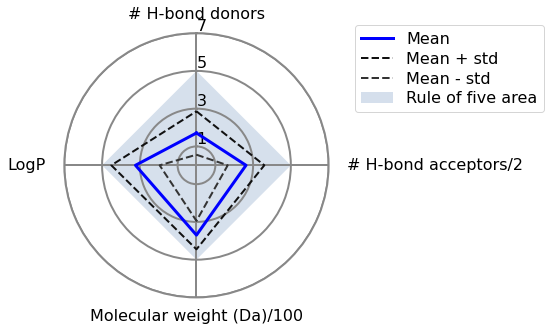

In [47]:
plot_radarplot(stats_rof, "C:/Users/Hp/Desktop/tactorials1234entrega/tactorial unido/radarplot_rof.png")

In the above created radar chart, the blue square shows the area where the physicochemical properties are within the rule of five. The blue line connects the mean values of our filtered dataset, while the dashed lines show the standard deviations. We can see that the mean values never violate any of Lipinski's rules. However, according to the standard deviation, some properties are still larger. This is acceptable; we have to keep in mind that one of the four property's rules may be violated.

Second, we take a look at the compounds that violate the rule of five.

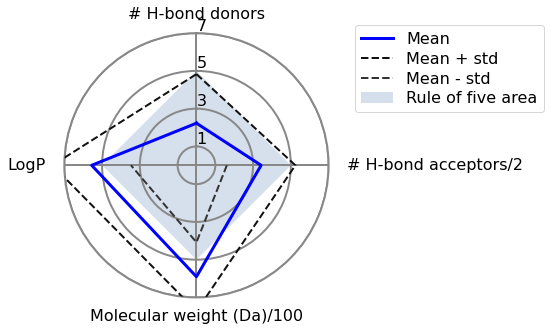

In [48]:
plot_radarplot(stats_not_rof, "C:/Users/Hp/Desktop/tactorials1234entrega/tactorial unido/radarplot_not_rof.png")

We see that compounds mostly violate the rule of five based on their logP value and their molecular weight.

# Talktorial 3

# Ligand-based screening: machine learning

#### Developed in the Pontificia Universidad Javeriana, Bogota/Colombia




## Aim of this talktorial

Due to larger available data sources, machine learning (ML) gained momentum in drug discovery and especially in ligand-based virtual screening. In this talktorial, we will learn how to use different supervised ML algorithms to predict the activity of novel compounds against our target of interest (ID Protein).

## Learning goals

* Different fingerprints to encode the molecules for usage in ML
* Different ML algorithms and their application
* Evaluation of ML model performance

### Theory

* Introduce different types of fingerprints
* Different types of supervised ML algorithms
* Model performance evaluation and measurements 

### Practical

* Set up and evaluation of a ML-based screening pipeline for potential ID Protein inhibitors

## References

* RdKit fingerprints, e.g. see [presentation by G. Landrum at rdkit UGM 2012](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf):
* ML:
    * Random forest (RF): [http://ect.bell-labs.com/who/tkh/publications/papers/odt.pdf](http://ect.bell-labs.com/who/tkh/publications/papers/odt.pdf)
    * Support vector machines (SVM): [https://link.springer.com/article/10.1007%2FBF00994018](https://link.springer.com/article/10.1007%2FBF00994018)
    * Artificial neural networks (ANN): [https://www.frontiersin.org/research-topics/4817/artificial-neural-networks-as-models-of-neural-information-processing](https://www.frontiersin.org/research-topics/4817/artificial-neural-networks-as-models-of-neural-information-processing)
* Performance: 
    * [Sensitivity_and_specificity (wikipedia)](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)
    * [Roc curve and AUC (wikipedia)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve)
* See also [git hub notebook by B. Merget](https://github.com/Team-SKI/Publications/tree/master/Profiling_prediction_of_kinase_inhibitors) from [*J. Med. Chem.*, 2017, 60, 474−485](https://pubs.acs.org/doi/10.1021/acs.jmedchem.6b01611) 

## Theory

<img src="./images/ML_overview.png" width="200" align='right'>

To successfully apply ML, we need a large data set of molecules, a molecular encoding, a label per molecule in the data set, and a ML algorithm to train a model. Then, we can make predictions for new molecules.

### Data preparation

For ML, molecules need to be converted into a list of features. Often molecular fingerprints are used as representation. 

Fingerprints used in this talktorial and implemented in rdkit (more info can be found in a  [presentation by G. Landrum](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf)):
* **maccs**: MACCS keys are 166 bit structural key descriptors in which each bit is associated with a SMARTS pattern.
* **ecfp4** and *ecfp6*: Extended-Connectivity Fingerprints (ECFPs) are circular topological fingerprints designed for molecular characterization, similarity searching, and structure-activity modeling. Most important parameters of ECFPs are maximum diameter and fingerprint length. The so called diameter specifies the maximum diameter of the circular neighborhoods considered for each atom. Here there are two diameters: 4 and 6. The length parameter specifies the length of the bit string representation. The default length is 2048.
* **torsion**: The Torsion Fingerprint Deviation (TFD) extracts, weights, and compares Torsion Fingerprints from a query molecule and generated conformations under consideration of acyclic bonds as well as ring systems.
* **rdk5**: rdk5 is a path based fingerprint. A path fingerprint is generated by exhaustively enumerating all linear fragments of a molecular graph up to a given size and then hashing these fragments into a fixed-length bit vector.

### Machine Learning (ML)

ML can be applied for (see also [scikit-learn page](http://scikit-learn.org/stable/)):

* **Classification (supervised)**: Identify to which category an object belongs (Nearest neighbors, Naive Bayes, RF, SVM, ...)
* Regression: Prediction of a continuous-values attribute associated with an object

#### Supervised learning

Learning algorithm creates rules by finding patterns in the training data. 
<img src="./images/RF_example.png" width="250" align='right'>
* **Random Forest (RF)**: Multiple decision trees which produce a mean prediction.

* **Support Vector Machines (SVM)**: SVMs can efficiently perform a non-linear classification using what is called the kernel trick, implicitly mapping their inputs into high-dimensional feature spaces. Classifier based on the idea of maximizing the margin as objective function.  

    <img src="./images/ANN_wiki.png" width="150" align='right'>
* **Artificial neural networks (ANNs)**: An ANN is based on a collection of connected units or nodes called artificial neurons which loosely model the neurons in a biological brain. Each connection, like the synapses in a biological brain, can transmit a signal from one artificial neuron to another. An artificial neuron that receives a signal can process it and then signal additional artificial neurons connected to it. (Figure from Wikipedia)
 
#### Validation strategy: K-fold cross validation

* This model validation technique splits the dataset in two groups in an iterative manner:
    * Training data set: Considered as the known dataset on which the model is trained
    * Test dataset: Unknown dataset on which the model is then tested
    * Process is repeated k-times
    
* The goal is to test the ability of the model to predict data which it has never seen before in order to flag problems known as over-fitting and to assess the generalization ability of the model.

#### Performance measures
<img src="./images/FP_TP_fig.png" width="250" align='right'>

* **Sensitivity**, also true positive rate: TPR = TP/(FN+TP)
* **Specificity**, also true negative rate: TNR = TN/(FP + TN)
* **Accuracy**, also the trueness: ACC = (TP + TN)/(TP + TN + FP + FN)
* **ROC-curve**, receiver operating characteristic curve
    * A graphical plot that illustrates the diagnostic ability of our classifier
    * Plots the sensitivity against the specificity
* **AUC**, the area under the roc curve (AUC):  
    * Describes the probability that a classifier will rank a randomly chosen positive instance higher than a negative one
    * Values between 0 and 1, the higher the better

In [49]:
# Import statements
# General:
import pandas as pd
import numpy as np

# rdkit:
from rdkit import Chem
from rdkit.Chem import RDKFingerprint
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem.AllChem import GetHashedTopologicalTorsionFingerprintAsBitVect
from rdkit.Chem import MACCSkeys
from rdkit.DataStructs import ConvertToNumpyArray

# sklearn:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
# from sklearn.manifold import MDS

# matplotlib:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# seaborn:
import seaborn as sns


### Data preparation
We will work on ID Protein (Epidermal growth factor receptor) kinase data for now.

But before starting, we will define two functions to help us creating the data frame we will work with.
The first method is named `calculate_fp` and calculates the molecular fingerprint of a molecule. The user has the choice between:
* maccs
* ecfp4 and ecfp6
* torsion
* rdk5 

In [50]:
def calculate_fp(mol, method='maccs', n_bits=2048):
    # mol = Chem molecule object
    # Function to calculate molecular fingerprints given the number of bits and the method
    if method == 'maccs':
        return MACCSkeys.GenMACCSKeys(mol)
    if method == 'ecfp4':
        return GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits, useFeatures=False)
    if method == 'ecfp6':
        return GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits, useFeatures=False)
    if method == 'torsion':
        return GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=n_bits)
    if method == 'rdk5':
        return RDKFingerprint(mol, maxPath=5, fpSize=1024, nBitsPerHash=2)

The second function helps us to create a data frame with the following additional columns:
* Our molecules as molecule objects (created SMILES-strings)
* The fingerprint as an python-object of the method of our choice (here MACCs)
* The bit-vector of the fingerprint method of our choice as binary representation

Therefore, we have two parameters: The data frame with a column named "smiles" with valid SMILES values, and the length of the fingerprint. The second argument is only used when others than MACCS fingerprint-method is chosen.

In [51]:
def create_mol(df_l, n_bits):
    # Construct a molecule from a SMILES string
    # Generate mol column: Returns a Mol object, None on failure.
    df_l['mol'] = df_l.smiles.apply(Chem.MolFromSmiles)
    # Create a column for storing the molecular fingerprint as fingerprint object
    df_l['bv'] = df_l.mol.apply(
        # Apply the lambda function "calculate_fp" for each molecule
        lambda x: calculate_fp(x, 'maccs', n_bits)
    )
    # Allocate np.array to hold fp bit-vector (np = numpy)
    df_l['np_bv'] = np.zeros((len(df_l), df_l['bv'][0].GetNumBits())).tolist()
    df_l.np_bv = df_l.np_bv.apply(np.array)
    # Convert the object fingerprint to NumpyArray and store in np_bv
    df_l.apply(lambda x: ConvertToNumpyArray(x.bv, x.np_bv), axis=1)


### Load data

Now let's start to load our data and to do the actual work. The *csv* file from **talktorial 2** is loaded into a dataframe with the important columns:

* the CHEMBL-ID
* the SMILES value of the corresponding compound
* pIC50

In [52]:
# Read data from previous talktorials
df = pd.read_csv('C:/Users/Hp/Desktop/tactorials1234entrega/T3/GSK3lan.csv', delimiter=';', index_col=0)
# Look at head
print(df.shape)
print(df.info())

(2036, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2036 entries, 0 to 2138
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   molecule_chembl_id    2036 non-null   object 
 1   units                 2036 non-null   object 
 2   IC50                  2036 non-null   float64
 3   smiles                2036 non-null   object 
 4   pIC50                 2036 non-null   float64
 5   MW                    2036 non-null   float64
 6   HBA                   2036 non-null   int64  
 7   HBD                   2036 non-null   int64  
 8   LogP                  2036 non-null   float64
 9   rule_of_five_conform  2036 non-null   object 
dtypes: float64(4), int64(2), object(4)
memory usage: 175.0+ KB
None


### Classify data
We need to classify each compound as active or inactive, therefore, we use the pIC50 value. 
* pIC50 = -log10(IC50) 
* IC50 describes the molar concentration (mol/L) that will result in 50 percent of inhibition in-vitro. 
* A common cut-off value to discretize pIC50 data is 6,3, which we will use for our experiment.
* Note that there are several other suggestions for an activity cut-off ranging from an pIC50 value of 5 to 7 in the literature or even to define an exclusion range when not to take data points. 

Now we can use our functions defined above to generate our molecules and their fingerprints 
as well as specifying which molecule is active and which is not. 

In [53]:
# Drop unnecessary columns
df_new=df.drop(['units', 'IC50'], axis=1)
# Create molecules from smiles and their fingerprints
create_mol(df_new, 2048)
# Add column for activity
df_new['active'] = np.zeros(len(df_new))

# Mark every molecule as active with an pIC50 of > 7.0
df_new.loc[df_new[df_new.pIC50 >= 7.0].index, 'active'] = 1.0
print('actives: %d, inactives: %d' % (df_new.active.sum(), len(df_new)-df_new.active.sum()))

actives: 729, inactives: 1307


,molecule_chembl_id,smiles,pIC50,MW,HBA,HBD,LogP,rule_of_five_conform,mol,bv,np_bv,active
0,CHEMBL2386094,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...,10.886057,514.165248,6,1,3.3616,yes,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
1,CHEMBL3895998,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1,10.000000,407.186987,7,3,2.4397,yes,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
2,CHEMBL4084855,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...,10.000000,392.196074,8,0,1.9610,yes,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0

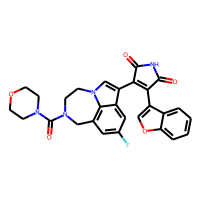
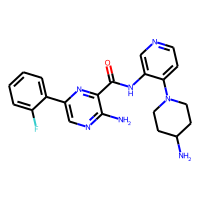
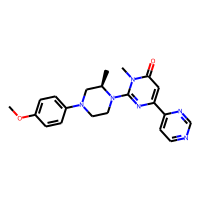

In [54]:
df_new.head(3)

### Machine Learning (ML)

In the following we will try several ML approaches to classify our molecules. We will use:
* Random Forest (RF)
* Support Vector Machines (SVM) 
* Artificial Neural Networks (ANNs) 

Additionally, we will comment on the results. But before we start we define a function named `crossvalidation` which executes a cross validation procedure and returns measures such as accuracy, sensitivity and specificity.

The goal is to test the ability of the model to predict data which it has never seen before in order to flag problems known as overfitting and to assess the generalization ability of the model.

In [55]:
# Function for a cross-validation loop.
def crossvalidation(model_l, df_l, n_folds=10):
    # Given the selected model, the dataFrame and the number of folds the function executes a crossvalidation and returns
    # accuracy, sensitivity, specificity for the prediction as well as fpr, tpr, roc_auc for each fold
    
    # Empty results vector
    results = []
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True)
    # Labels initialized with -1 for each data-point
    labels = -1 * np.ones(len(df_l))
    # Loop over the folds
    for train_index, test_index in kf.split(df_l):
        # Training
        # Convert the bit-vector and the label to a list
        train_x = df_l.iloc[train_index].bv.tolist()
        train_y = df_l.iloc[train_index].active.tolist()
        # Fit the model
        model_l.fit(train_x, train_y)

        # Testing
        # Convert the bit-vector and the label to a list
        test_x = df_l.iloc[test_index].bv.tolist()
        test_y = df_l.iloc[test_index].active.tolist()
        # Predict on test-set
        prediction_prob = model_l.predict_proba(test_x)[:, 1]
        # Save the predicted label of each fold
        labels[test_index] = model_l.predict(test_x)

        # Performance
        # Get fpr, tpr and roc_auc for each fold
        fpr_l, tpr_l, _ = roc_curve(test_y, prediction_prob)
        roc_auc_l = auc(fpr_l, tpr_l)
        # Append to results
        results.append((fpr_l, tpr_l, roc_auc_l))

    # Get overall accuracy, sensitivity, specificity
    y = df_l.active.tolist()
    acc = accuracy_score(df_l.active.tolist(), labels)
    sens = recall_score(df_l.active.tolist(), labels)
    spec = (acc * len(y) - sens * sum(y)) / (len(y) - sum(y))
    return acc, sens, spec, results


Of course we want to assess the quality of our models. Therefore we want to know the accuracy, sensitivity and specificity of our prediction. Additionally we focus on the so called ROC-curve. 

For reasons of clarity and comprehensibility of our code, we build a small function to plot our results. 

We will focus shortly on the following aspects:
* Sensitivity
* Specificity
* Accuracy
* ROC-curve and AUC

In [56]:
np.linspace(0.1, 1.0, 10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [57]:
def print_results(acc, sens, spec, stat_res, main_text, file_name, plot_figure=1):
    plt.figure(plot_figure, figsize=(7, 7))
    cmap = cm.get_cmap('Blues')
    
    colors = [cmap(i) for i in np.linspace(0.3, 1.0, 10)]
    #colors = ["#3465A4"]
    for i, (fpr_l, tpr_l, roc_auc_l) in enumerate(stat_res):
        plt.plot(fpr_l, tpr_l, label='AUC CV$_{0}$ = {1:0.2f}'.format(str(i),roc_auc_l), lw=2, color=colors[i])
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random', lw=2, color="black")  # Random curve
    plt.xlabel('False positive rate', size=24)
    plt.ylabel('True positive rate', size=24)
    plt.title(main_text, size=24)
    plt.tick_params(labelsize=16)
    plt.legend(fontsize=16)
    
    # Save plot - use bbox_inches to include text boxes:
    # https://stackoverflow.com/questions/44642082/text-or-legend-cut-from-matplotlib-figure-on-savefig?rq=1
    plt.savefig("C:/Users/Hp/Desktop/tac torials/resultados t1/" + file_name, dpi=300, bbox_inches="tight", transparent=True)
    
    plt.show()
    # Calculate mean AUC and print
    m_auc = np.mean([elem[2] for elem in r[3]])
    print('Mean AUC: {}'.format(m_auc))

    # Show overall accuracy, sensitivity, specificity
    print('Sensitivity: {}\nAccuracy: {}\nSpecificity: {}\n'.format(acc, sens, spec))
    print('\t7')


### Random forest classifier

Now we will start with a random forest classifier. We will first set the parameters. Afterwards we will do the cross validation of our model and plot the results. 

In [58]:
# Set model parameter for random Forest
param = {'max_features': 'auto',
         'n_estimators': 2000,
         'criterion': 'entropy',
         'min_samples_leaf': 1}
modelRf = RandomForestClassifier(**param)

# Do cross-validation procedure with 10 folds
r = crossvalidation(modelRf, df_new, 10)

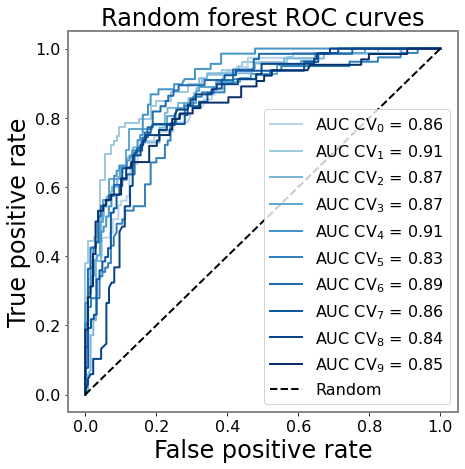

Mean AUC: 0.8675664128484712
Sensitivity: 0.8005893909626719
Accuracy: 0.6776406035665294
Specificity: 0.8691660290742158

	7


In [59]:
# Plot the AUC results
# r contains acc, sens, spec, and results
print_results(r[0], r[1], r[2], r[3], 'Random forest ROC curves', 'rf_roc.png', 3)


Our models shows very good values for all measured values and, thus, seem to be predictive.

### Support vector classifier
Here we train a Support vector machine with a Radial-basis function kernel (also: squared-exponential kernel). 
For more information see [sklearn RBF kernel](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html).

In [60]:
# Specify model
modelSvm = svm.SVC(kernel='rbf', C=1, gamma=0.1, probability=True)

# Do cross-validation procedure with 10 folds
r = crossvalidation(modelSvm, df_new, 10)

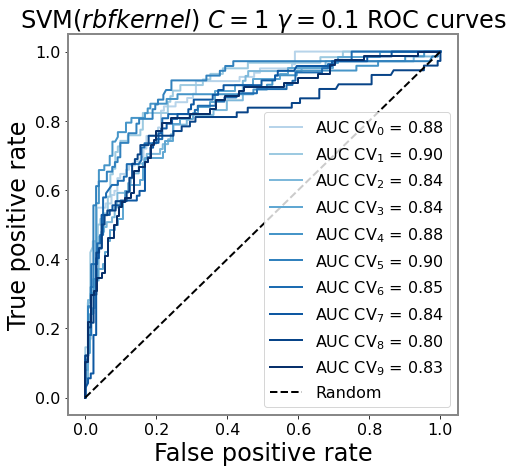

Mean AUC: 0.8560812446690849
Sensitivity: 0.7956777996070727
Accuracy: 0.6200274348422496
Specificity: 0.8936495791889824

	7


In [61]:
# Plot results
print_results(r[0], r[1], r[2], r[3],
              'SVM$(rbf kernel)$ $C=1$ $\gamma=0.1$ ROC curves', 'svm_roc.png', 3)

### Neural network classifier
The last approach we try here is a neural network model. We train an MLPClassifier (Multi-layer Perceptron classifier) with 3 layers, each with 5 neurons. You may notice early stopping is explicitely set to FALSE. As before, we do the crossvalidation procedure and plot the results. For more infor on MLP, see [sklearn MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).

In [62]:
# Specify model, default activation: relu
modelClf = MLPClassifier(solver='adam', 
                         alpha=1e-5, 
                         hidden_layer_sizes=(5, 3), 
                         random_state=1, early_stopping=False)

# Do cross-validation procedure with 10 folds
r = crossvalidation(modelClf, df_new, 10)

C:\Users\Hp\anaconda3\envs\chemi\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Hp\anaconda3\envs\chemi\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Hp\anaconda3\envs\chemi\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Hp\anaconda3\envs\chemi\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conver

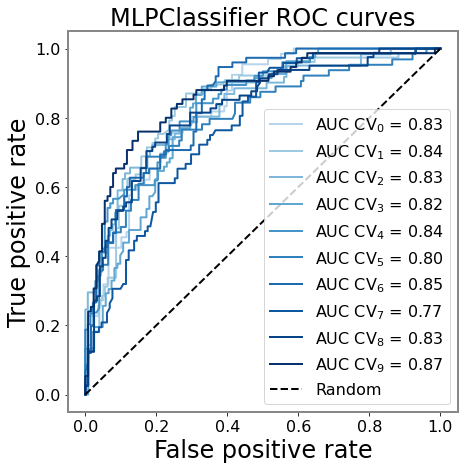

Mean AUC: 0.8272066862432274
Sensitivity: 0.7554027504911591
Accuracy: 0.6392318244170097
Specificity: 0.8201989288446825

	7


In [63]:
# Plot results
print_results(r[0], r[1], r[2], r[3], 'MLPClassifier ROC curves', 'mlp_roc.png', 3)

## Discussion TALKTORIAL 1

In this tutorial, we collected all available bioactivity data for our target of interest from the ChEMBL database. We filtered the data set to only contain molecules with measured IC50 or pIC50 bioactivity values. 

Be aware that ChEMBL data originates from various sources. Compound data has been generated in different labs by different people all over the world. Therefore, we have to be cautious with the predictions we make using this dataset. It is always important to consider the source of the data and consistency of data production assays when interpreting the results and determining how much confidence we have in our predictions.

In the next tutorials we will filter our acquired data by the Lipinski rule of five and by unwanted substructures. Another important step would be to clean the data and remove duplicates. As this is not shown in any of our talktorials (yet), we would like to refer to the standardiser library ([github Francis Atkinson](https://github.com/flatkinson/standardiser)) or [MolVS](https://molvs.readthedocs.io/en/latest/) as possible tools for this task.

## Quiz

* We have downloaded in this talktorial molecules and bioactivity data from ChEMBL. What else is the ChEMBL database useful for?
* What is the difference between IC50 and EC50?
* What can we use the data extracted from ChEMBL for?

## Discussion Talktorial 2


Lipinski's rule of five focuses on oral bioavailability. Drugs can also be administered via alternative routes, i.e. inhalation, skin penetration and injection. Be aware, that the rule of five is a guide for estimation of oral bioavailability, there are exceptions in both ways. With bioavailability, we have looked at one of several ADME properties. 

There are webservers/programmes available to get a whole picture of ADME properties, e.g. [SwissADME](http://www.swissadme.ch/).
### Calculate rule of five molecular properties and plot them

The chemical properties relevant for the rule of five are calculated and visually compared:

* Calculate molecular weight, number of h-bond acceptors and donors, and logP.
*  Using the predefined functions in the [rdkit descriptor library](http://www.rdkit.org/docs/GettingStartedInPython.html#descriptor-calculation)


## Quiz
* In what way can the chemical properties described by the rule of five affect ADME?
* Find or design a molecule which violates three or four rules. 
* How can you plot information of an additional molecule in the above created radar chart?

## Discussion Talktorial 3

* Which model performed best on our data set and why?
    * All three models perform (very) good on our dataset. The best models are the random forest and support vector machine models which showed a mean AUC of 90%. Our neuronal network showed slightly lower results with a mean AUC of 87%. (Note values can slightly differ if you rerun the script.)
    * There might be several reasons that the random forest and support vector machine models performed best. Our dataset might be easily separable in active/inactive with some simple tree-like decisions or with the radial basis function, respectively. Thus, there is not such a complex pattern in the fingerprints to do this classification.
    * A cause for the slightly poorer performance of the ANN, could be that there was simply too few data to train the model on.
    * Additionally, it is always advisable to have another external validation set for model evaluation.
    
* Was MACCS the right choice?
    * Obviously, MACCS was good to start training and validating models to see if a classification is possible. 
    * But since MACCS fingerprints are rather short (166 bit) compared to others (2048 bit), one should try different fingerprints and repeat the validation process.

    
### Where can we go from here?

* We successfully trained several models. 
* The next step is to use these models to do a classification with an unknown screening dataset to predict novel potential EGFR inhibitors.
* An example for a large screening data set is e.g. [MolPort](https://www.molport.com/shop/database-download) with over 7 million compounds.
* Our models could be used to rank the MolPort compounds and then further study those with the highest predicted probability of being active.
* For an application of such see also the [TDT Tutorial](https://github.com/sriniker/TDT-tutorial-2014) developed by S. Riniker and G. Landrum, where they trained a fusion model to screen [eMolecules](https://www.emolecules.com/) for new anti-malaria drugs.


### Quiz

* How can you apply ML for virtual screening?
* Which machine learning algorithms do you know?
* What are necessary prerequisites to successfully apply ML?